In [6]:
# Import all functions

import cv2
from tqdm import tqdm
import pandas as pd
import glob
import os
import numpy as np
import matplotlib.pyplot as plt
import json
from multiprocess import Pool
from time import time
from functools import partial
plt.rcParams['figure.figsize'] = [10, 10]
import seaborn as sns
import datetime

import sys
import cvfunc
import scale
import symmetry

from cvfunc import color_threshold,auto_crop,symmetric_shift


In [2]:
#
# The Color Palette to use:
#

# BGR and repeated: [B,G,R,B,G,R] 
# Added/subtracted an adjustment, to give color values a range, i.e. [B-2,G-2,R-2,B+2,G+2,R+2]

adj=10 # had to make this larger, because there's color "noise" in the shrinked images

# want to be able to give a RANGE of color values, but can't go under 0, or above 255. Use inbetween function:
def lim(minv, val, maxv):
    return min(maxv, max(minv, val))

# The color palette from 2021: USE THIS ONE
# NOTE: BGR values from color picker is not necesarily accurate, 
# so make sure to pick out the colors using the "color_lab" (or below)
# uncertain about DC colors for capped honey, nectar, pollen (put the ?)

color_palette = {
"bg":[255,255,255,255,255,255],
"uncapped_brood":[lim(0, 240-adj, 255), lim(0, 174-adj, 255), lim(0, 0-adj, 255), 
                  lim(0, 240+adj, 255), lim(0, 174+adj, 255), lim(0, 0+adj, 255)],
"uncapped_brood_d":[lim(0, 145-adj, 255), lim(0, 105-adj, 255), lim(0, 1-adj, 255), 
                    lim(0, 145+adj, 255), lim(0, 105+adj, 255), lim(0, 1+adj, 255)],
"capped_brood":[lim(0, 255-adj, 255), lim(0, 0-adj, 255), lim(0, 0-adj, 255), 
                lim(0, 255+adj, 255), lim(0, 0+adj, 255), lim(0, 0+adj, 255)],
"capped_brood_d":[lim(0, 136-adj, 255), lim(0, 0-adj, 255), lim(0, 0-adj, 255), 
                  lim(0, 136+adj, 255), lim(0, 0+adj, 255), lim(0, 0+adj, 255)],
"nectar":[lim(0, 86-adj, 255), lim(0, 255-adj, 255), lim(0, 255-adj, 255), 
          lim(0, 86+adj, 255), lim(0, 255+adj, 255), lim(0, 255+adj, 255)],
"nectar_d?":[lim(0, 60-adj, 255), lim(0, 183-adj, 255), lim(0, 183-adj, 255), 
            lim(0, 60+adj, 255), lim(0, 183+adj, 255), lim(0, 183+adj, 255)],
"honey":[lim(0, 197-adj, 255), lim(0, 255-adj, 255), lim(0, 216-adj, 255), 
         lim(0, 197+adj, 255), lim(0, 255+adj, 255), lim(0, 216+adj, 255)],
"honey_d?":[lim(0, 185-adj, 255), lim(0, 210-adj, 255), lim(0, 168-adj, 255), 
           lim(0, 185+adj, 255), lim(0, 210+adj, 255), lim(0, 168+adj, 255)],
"empty":[lim(0, 92-adj, 255), lim(0, 92-adj, 255), lim(0, 92-adj, 255), 
         lim(0, 92+adj, 255), lim(0, 92+adj, 255), lim(0, 92+adj, 255)],
"empty_d":[lim(0, 0-adj, 255), lim(0, 0-adj, 255), lim(0, 0-adj, 255), 
           lim(0, 0+adj, 255), lim(0, 0+adj, 255), lim(0, 0+adj, 255)],
"pollen":[lim(0, 34-adj, 255), lim(0, 101-adj, 255), lim(0, 242-adj, 255), 
          lim(0, 34+adj, 255), lim(0, 101+adj, 255), lim(0, 242+adj, 255)],
"pollen_d?":[lim(0, 29-adj, 255), lim(0, 60-adj, 255), lim(0, 127-adj, 255), 
            lim(0, 29+adj, 255), lim(0, 60+adj, 255), lim(0, 127+adj, 255)]    
}

# The color palette from 2013: 
# color_palette = {
# "bg":[255,255,255,255,255,255],
# "brood":[35,50,236,35,50,236],
# "brood_d":[128,117,227,128,117,227],
# "honey":[245,33,0,245,33,0],
# "honey_d":[252,251,117,252,251,117],
# "empty":[75,250,117,75,250,117],
# "empty_d":[161,210,172,161,210,172],
# "pollen":[61,151,235,61,151,235]
# }

search_ratio = 0.05

In [4]:
# Paths:

# these are the original full-sized images: 
original_images_path = '/Users/michaelsmith/Documents/GitHub/symmetry_optimizer/original_images/*/'

# first step will be to apply the symmetric shift: 
symmetric_shift_images_path = '/Users/michaelsmith/Documents/GitHub/symmetry_optimizer/symmetric_shift_images/'

# THEN scale them down (otherwise get rough edges from the symmetric shift):
scaled_images_path = "/Users/michaelsmith/Documents/GitHub/symmetry_optimizer/shrink"



In [7]:
# FIRST apply the symmetric shift to each image: 

for file in tqdm(glob.glob(original_images_path+"/*.png"),desc="Progress"): # be sure to have .PNG file! 
    original = cv2.imread(file)
    symmetric_shifted = symmetric_shift(original)
    savestring = os.path.join(symmetric_shift_images_path,f"{os.path.splitext(os.path.basename(file))[0]}.png")
    cv2.imwrite(savestring,symmetric_shifted)


Progress: 100%|██████████| 6/6 [00:42<00:00,  7.03s/it]


In [8]:
# THEN resize them: 
# Ideally, the height would be 100 px, but need to remove white space

for file in tqdm(glob.glob(symmetric_shift_images_path+"/*.png"),desc="Progress"): # be sure to have .PNG file! 
    image = cv2.imread(file)
    resized = scale.resize(image,100) # height, in PX - NOW AT 100 PX!!! (obs hive is 100cm high, 1px=1cm=2x2cells)
    savestring = os.path.join(scaled_images_path,f"{os.path.splitext(os.path.basename(file))[0]}.png")
    cv2.imwrite(savestring,resized)


Progress: 100%|██████████| 6/6 [00:01<00:00,  3.12it/s]


In [ ]:
### NOTE: STILL NEED TO REMOVE EXCESS WHITE SPACE ###
### NOTE: The shrink images still have a few pixels that deviate from the palette ###

/Users/michaelsmith/Documents/GitHub/symmetry_optimizer/shrink/East_day105_16Apr2013_S.png


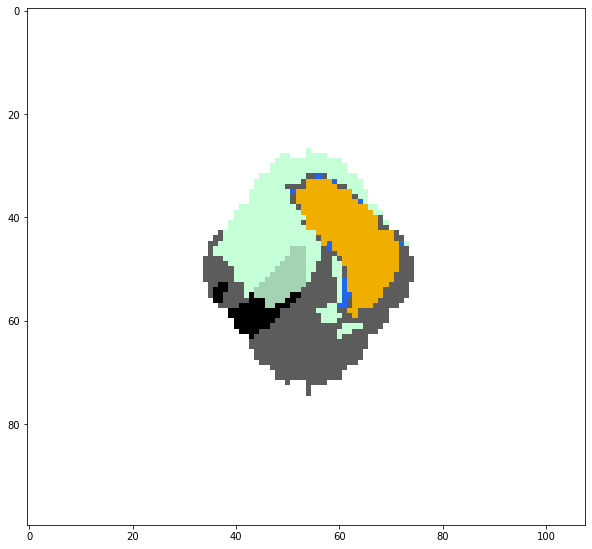

/Users/michaelsmith/Documents/GitHub/symmetry_optimizer/shrink/East_day105_16Apr2013_N.png


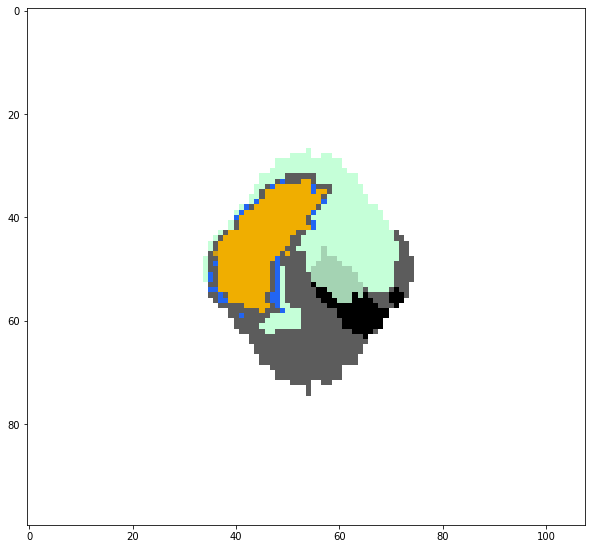

/Users/michaelsmith/Documents/GitHub/symmetry_optimizer/shrink/Office_day261_18Sep2013_W.png


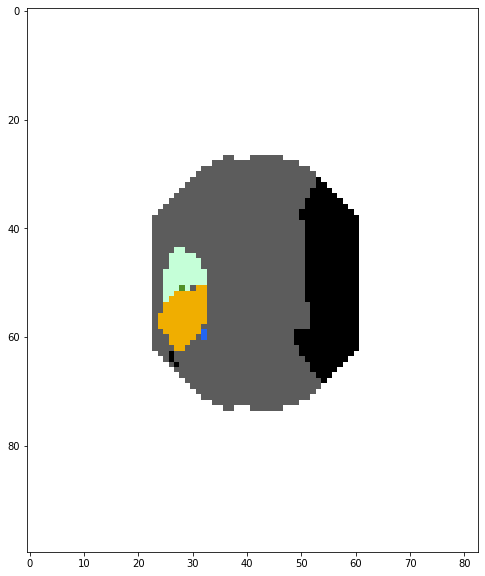

/Users/michaelsmith/Documents/GitHub/symmetry_optimizer/shrink/Office_day261_18Sep2013_mirror.png


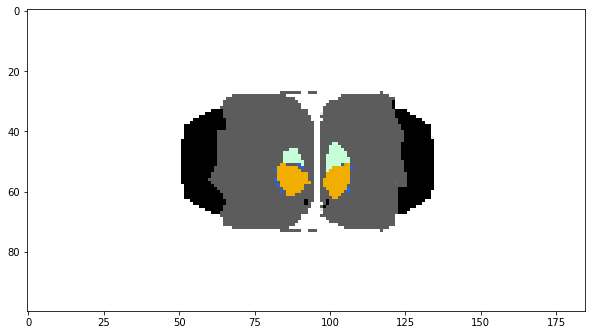

/Users/michaelsmith/Documents/GitHub/symmetry_optimizer/shrink/Office_day261_18Sep2013_E.png


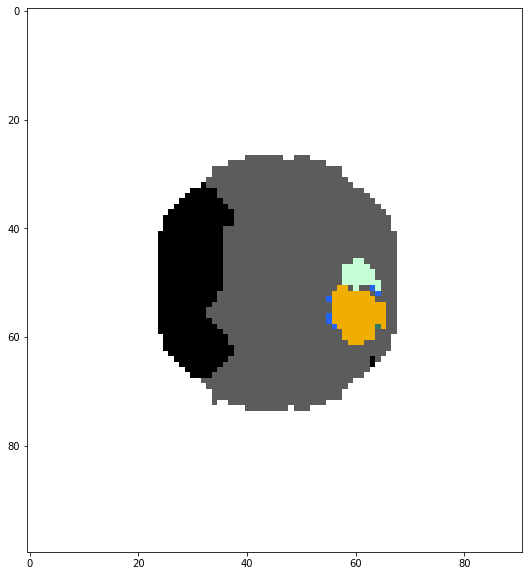

/Users/michaelsmith/Documents/GitHub/symmetry_optimizer/shrink/East_day105_16Apr2013_mirror.png


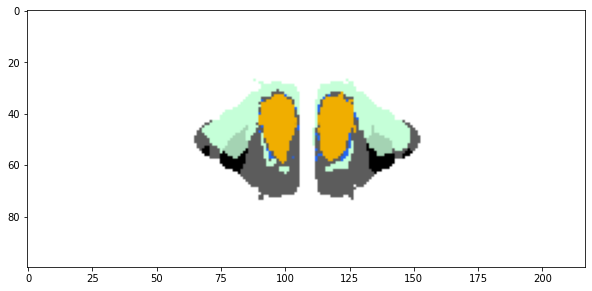

In [11]:
# Just for early versions, show all images to make sure all good: 

glob_str = scaled_images_path+'/*'
filenames = glob.glob(glob_str)

for i in filenames:
    print(i)
    img = cv2.imread(i)
    plt.imshow(img)
    plt.show()

In [ ]:

# Here is where we make the overall dataframe
# Uses symmetry.process_one

# THIS is where it would be important to incorporate a baseline symmetry
# i.e. we use symmetry.process_one to calculate the symmetry, but take into account the overall image
# (the original way I was going to do this was by shuffling the image, and subtracting the shuffled value from the observed value)



In [12]:

print(datetime.datetime.now())

each_img_dfs=[]

for i in filenames:
    print(i)
    img = cv2.imread(i) # import the image
    d0,pictures0 = symmetry.process_one(img,search_ratio,color_dict=color_palette,angle=0,auto_crop=False) # angle 0 = vertical line
    d90,pictures90 = symmetry.process_one(img,search_ratio,color_dict=color_palette,angle=90,auto_crop=False) # angle 90 = horizontal
    # convert lists to dataframe
    d0 = pd.DataFrame(d0)
    d0["filename"] = i
    d90 = pd.DataFrame(d90)
    d90["filename"] = i
    
    # is_mirrored = ("left" in i) and ("right" in i)
    is_mirrored = ("irror" in i) # changed this to "irror" because sometimes it's lower case m, sometimes upper case
    d0["mirrored"] = is_mirrored
    d90["mirrored"] = is_mirrored
    
    # add COLONY: 
    d0['colony'] = i.rsplit('/',1)[-1].rsplit('_')[0]
    d90['colony'] = i.rsplit('/',1)[-1].rsplit('_')[0]
    
    # add EXP DATE, as an integer:
    d0['expday'] = int(i.rsplit('/',1)[-1].rsplit('_')[1][3:])
    d90['expday'] = int(i.rsplit('/',1)[-1].rsplit('_')[1][3:])
    
    # add DATE (right now its a string, would also be useful as a datetime)
    d0['date'] = i.rsplit('/',1)[-1].rsplit('_')[2]
    d90['date'] = i.rsplit('/',1)[-1].rsplit('_')[2]
    
    # SIDE of the nest
    d0['side'] = i.rsplit('/',1)[-1].rsplit('_')[3]
    d90['side'] = i.rsplit('/',1)[-1].rsplit('_')[3]
    
    #[ICARO]This part will calculate the "size" of the pictures as a pixel count.
    d0["pixel_count"] = list(map(lambda x: (x["fig"]!=0).sum() ,pictures0))
    d90["pixel_count"] = d0["pixel_count"]
    
    # append the dataframes to list
    each_img_dfs.append(d0)
    each_img_dfs.append(d90)
    
# concatenate all the dataframes into one: 
all_dfs=pd.concat(each_img_dfs, ignore_index=True)

#[ICARO]In order to flip the scores so that the highest symmetry is 1: 
all_dfs["score_COR_flip"] = 1-all_dfs["score_COR"]

# ADD something that tells you if its' X, Y, or Z-axis symmetry... 
# so, if mirrored = false, then angle 0 = X-axis symmetry (left-right), angle 90 = Y-axis symmetry (top-bottom)
# if mirrored = TRUE, then angle 0 = Z-axis symmetry (opposite sides), and angle 90, we can ignore
def conditions(s):
    if (s['mirrored'] == False) and (s['angle'] == 0):
        return 'X-axis'
    elif (s['mirrored'] == False) and (s['angle'] == 90):
        return 'Y-axis'
    elif (s['mirrored'] == True) and (s['angle'] == 0):
        return 'Z-axis'
    else:
        return 'NA'

all_dfs['sym_type'] = all_dfs.apply(conditions, axis=1)

print(datetime.datetime.now())
    


2021-11-16 00:06:08.072717
/Users/michaelsmith/Documents/GitHub/symmetry_optimizer/shrink/East_day105_16Apr2013_S.png
process_one 0.02749800682067871
process_one 0.02808403968811035
/Users/michaelsmith/Documents/GitHub/symmetry_optimizer/shrink/East_day105_16Apr2013_N.png
process_one 0.024055004119873047
process_one 0.024552106857299805
/Users/michaelsmith/Documents/GitHub/symmetry_optimizer/shrink/Office_day261_18Sep2013_W.png
process_one 0.010971784591674805
process_one 0.011726856231689453
/Users/michaelsmith/Documents/GitHub/symmetry_optimizer/shrink/Office_day261_18Sep2013_mirror.png
process_one 0.05464768409729004
process_one 0.06368422508239746
/Users/michaelsmith/Documents/GitHub/symmetry_optimizer/shrink/Office_day261_18Sep2013_E.png
process_one 0.02117466926574707
process_one 0.023184776306152344
/Users/michaelsmith/Documents/GitHub/symmetry_optimizer/shrink/East_day105_16Apr2013_mirror.png
process_one 0.05707287788391113
process_one 0.06406092643737793
2021-11-16 00:06:08.55

In [13]:
all_dfs

,angle,x_MSE,score_MSE,x_COR,score_COR,id,R,G,B,filename,mirrored,colony,expday,date,side,pixel_count,score_COR_flip,sym_type
0,0,53.0,0.006999,53.0,0.674658,composition,1.000000,1.000000,1.000000,/Users/michaelsmith/Documents/GitHub/symmetry_...,False,East,105,16Apr2013,S.png,3248,0.325342,X-axis
1,0,53.0,0.007091,53.0,0.939623,uncapped_brood,0.901961,0.643137,0.000000,/Users/michaelsmith/Documents/GitHub/symmetry_...,False,East,105,16Apr2013,S.png,530,0.060377,X-axis
2,0,53.0,0.003975,53.0,0.743316,honey,0.733333,0.960784,0.807843,/Users/michaelsmith/Documents/GitHub/symmetry_...,False,East,105,16Apr2013,S.png,1122,0.256684,X-axis
3,0,53.0,0.001798,53.0,0.404444,empty,0.321569,0.321569,0.321569,/Users/michaelsmith/Documents/GitHub/symmetry_...,False,East,105,16Apr2013,S.png,1350,0.595556,X-axis
4,0,53.0,0.030769,53.0,1.000000,empty_d,0.000000,0.000000,0.000000,/Users/michaelsmith/Documents/GitHub/symmetry_...,False,East,105,16Apr2013,S.png,0,0.000000,X-axis
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
67,90,107.0,0.001866,107.0,0.500931,uncapped_brood,0.901961,0.643137,0.000000,/Users/michaelsmith/Documents/GitHub/symmetry_...,True,East,105,16Apr2013,mirror.png,1074,0.499069,NA
68,90,107.0,0.002238,107.0,0.830189,honey,0.733333,0.960784,0.807843,/Users/michaelsmith/Documents/GitHub/symmetry_...,True,East,105,16Apr2013,mirror.png,2226,0.169811,NA
69,90,107.0,0.001709,107.0,0.738426,empty,0.321569,0.321569,0.321569,/Users/michaelsmith/Documents/GitHub/symmetry_...,True,East,105,16Apr2013,mirror.png,2592,0.261574,NA
70,90,107.0,0.014184,107.0,1.000000,empty_d,0.000000,0.000000,0.000000,/Users/michaelsmith/Documents/GitHub/symmetry_...,True,East,105,16Apr2013,mirror.png,0,0.000000,NA


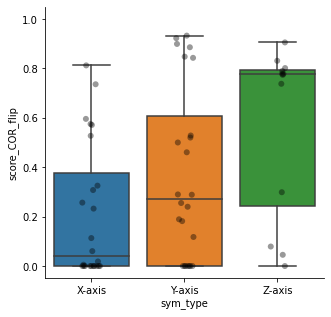

In [14]:
plt.figure(figsize=(5,5))
sns.boxplot(x='sym_type', y='score_COR_flip',
                data=all_dfs[all_dfs['sym_type']!='NA']) # take out the NA class

sns.stripplot(x = "sym_type",
              y = "score_COR_flip",
              color='black',
              s=6, alpha=0.4,
              # jitter=0.1,
              data = all_dfs[all_dfs['sym_type']!='NA'])

sns.despine()
plt.ylim(-0.05,1.05)
# plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.show()


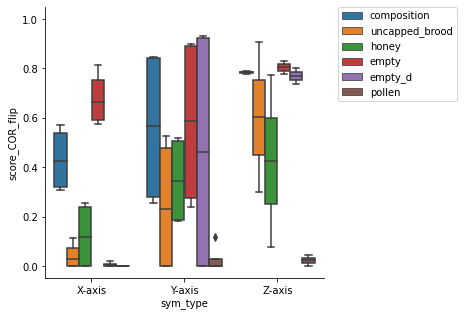

In [15]:
plt.figure(figsize=(5,5))
sns.boxplot(x='sym_type', y='score_COR_flip',
                hue='id', 
                data=all_dfs[all_dfs['sym_type']!='NA']) # take out the NA class

plt.ylim(-0.05,1.05)
sns.despine()
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)